## LangGraph Test File
Refer to the [LangGraph Tutorial](https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot) for more details.

In [1]:
import os
from dotenv import load_dotenv

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langchain_community.chat_models import ChatOllama
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

In [2]:
load_dotenv()

True

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## Schemas are the most imporatant part of every graph
The first thing you do when you define a graph is define the State of the graph. The State consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. In our example State is a TypedDict with a single key: messages. The messages key is annotated with the add_messages reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it. State keys without an annotation will be overwritten by each update, storing the most recent value. Check out this conceptual guide to learn more about state, reducers and other low-level concepts. 

In [4]:
llm = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"))
fast_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
local_llm = ChatOllama(model="llama3:latest")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


def fast_chatbot(state: State):
    return {"messages": [fast_llm.invoke(state["messages"])]}

def local_chatbot(state: State):
    return {"messages": [local_llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# # the node is used.
# graph_builder.add_node("chatbot", chatbot)
# graph_builder.add_node("fast_chatbot", fast_chatbot)
graph_builder.add_node("local_chatbot", local_chatbot)

In [5]:
# graph_builder.add_edge(START, "chatbot")
# graph_builder.add_edge(START, "fast_chatbot")
# graph_builder.add_edge("fast_chatbot", "chatbot")
# graph_builder.add_edge("chatbot", END)
graph_builder.add_edge(START, "local_chatbot")
graph_builder.add_edge("local_chatbot", END)

In [6]:
graph = graph_builder.compile()

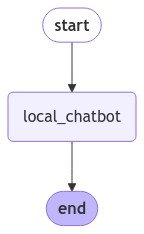

In [7]:
def draw_graph(graph: CompiledStateGraph):
    display(Image(graph.get_graph().draw_mermaid_png()))

draw_graph(graph)

In [8]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

KeyboardInterrupt: 